# Binary Classification - Transfer Learning with ResNet50
---

#### Step 0.0 : Initialize Dependencies

In [46]:
#CUDA driver verison: 10.1.243
#TensorFlow: 1.14.0
#OpenCV version: 4.5.1
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)
import os
from datetime import datetime
import pandas as pd
import tkinter as tk
import tkinter.filedialog
from sklearn.model_selection import train_test_split

%matplotlib inline
print("CUDA version:")
!nvcc --version
print("\nTensorFlow version:", tf.__version__)
print("\nOpenCV version:", cv2.__version__)
print("\nSuccessful!")

CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0

TensorFlow version: 1.14.0

OpenCV version: 4.5.1

Successful!


# 1.0 Data Pre-Processing
---

#### 1.1 : Basic image processing, cropping and resizing

In [2]:
def process_grayscale(img, contrast=1.1, brightness=-120, style="square"):
    if style.lower() == "increased_width":
        x0 = 300
        y0 = 150
        x1 = -160
        y1 = -50
        cropped_img = img[y0:y1, x0:x1]

        scalling_factor = 3
        height, width = cropped_img.shape[0], cropped_img.shape[1]
        new_dims = int(width / scalling_factor), int(height / scalling_factor)
        resized_img = cv2.resize(cropped_img, new_dims)
        
    elif style.lower() == "square":
        x0 = 350
        y0 = 180
        x1 = -150
#         y1 = -1 #-100 if class_folder == "Defected" else -50
        cropped_img = img[y0:, x0:x1]
        resized_img = cv2.resize(cropped_img, (224, 224)) # Xception NN

#     final_img = cv2.convertScaleAbs(resized_img, alpha=contrast, beta=brightness)
    return resized_img

#### 1.2 : Convert the image dataset into NumPy array

In [8]:
#the following function reads the dataset images saves them into NumPy arrays
def generate_dataset(data_path, oneToOne):
    date_time = datetime.today().strftime("%Y%m%d_%H%M")
    model_used = "ResNet50"

    X = []
    Y = []
    CLASSES = ["class1", "class2"]

    main_data_path = data_path
    for class_folder in os.listdir(main_data_path): # class1 , class2

        class_path = os.path.join(main_data_path, class_folder) #
        if class_folder.lower() == CLASSES[0].lower():
            num_c1 = len(os.listdir(class_path))
        elif class_folder.lower() == CLASSES[1].lower():
            num_c2 = len(os.listdir(class_path))

        i = 0 # maximum number of samples
        for img_file in os.listdir(class_path):
            print('processing...')
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            style="square"
            final_img = process_grayscale(img_rgb)
            #plt.imshow(final_img, cmap='gray')
            #plt.show()

            X.append(final_img)
            Y.append(CLASSES.index(class_folder))

            i += 1
            if oneToOne and i == num_c2:
                break

    if oneToOne:
        num_c2 = i
        print("equal dataset")
    else:
        print("unequal dataset")
    assert len(X) == len(Y)
    images, labels = np.array(X, dtype=float), np.array(Y)
    assert images.shape[0] == labels.shape[0]


    print("Image dimensions (after processing): ", images[0].shape)

    print("Number of samples: ", len(X))
    m_all_c1, m_all_c2 = np.bincount(Y)[0], np.bincount(Y)[1]
    print("Amount of Class1 samples: ", m_all_c1)
    print("Amount of Class2 samples: ", m_all_c2)
    print("Ratio of Class1 to Class2 samples: 1/", int(np.round(m_all_c2/m_all_c1)), sep='')

    np.save("processed_data/Square224imagesRGB" + date_time  + "_" + style + "_" + str(num_c1) + "-" + str(num_c2) + "_" + model_used + ".npy", images)
    np.save("processed_data/Square224labelsRGB" + date_time  + "_" + style + "_" + str(num_c1) + "-" + str(num_c2) + "_" + model_used + ".npy", labels)

    print("\n\nSaved!")

#### 1.3: The code below will prompt to select the data folder. Select the folder containing the class folders

Choosen folder: /home/venket/Binary-Classification---ResNet50/data


processing...


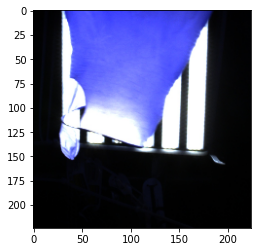

processing...


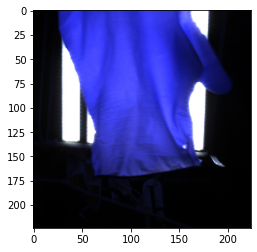

processing...


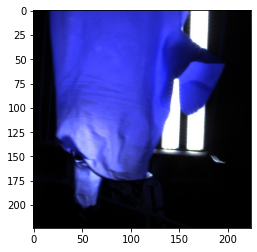

processing...


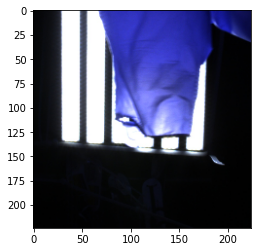

processing...


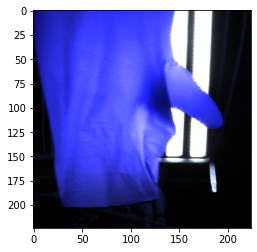

processing...


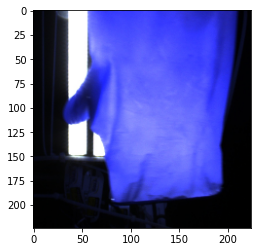

processing...


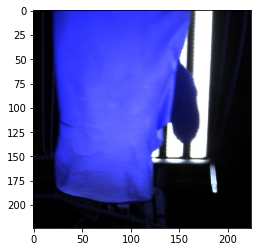

processing...


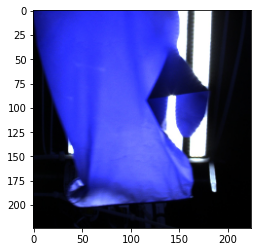

equal dataset
Image dimensions (after processing):  (224, 224, 3)
Number of samples:  8
Amount of Class1 samples:  4
Amount of Class2 samples:  4
Ratio of Class1 to Class2 samples: 1/1


Saved!


In [10]:
root = tk.Tk()
main_images_folder = tkinter.filedialog.askdirectory()
root.destroy()
print("Choosen folder:", main_images_folder + "\n\n")
data_path = main_images_folder
oneToOne = True #if dataset is equal for both classes change to True
generate_dataset(data_path, oneToOne)

# 3.0 Loading and data preparation
---

#### 3.1 : Loading the processed data and perform train - test split
#### (The train test split is performed twice to split them into train, test and validation set

In [3]:
root = tk.Tk()
processed_images_file = tkinter.filedialog.askopenfilename(title="Select the generated processed images file (NumPy array file)", initialdir="./processed_data")
processed_labels_file = tkinter.filedialog.askopenfilename(title="Select the generated processed labels file (NumPy array file)", initialdir="./processed_data")
root.destroy()

images = np.load(processed_images_file)
# images = np.expand_dims(orig_images, axis=-1) ## Only needed if grayscale
labels = np.load(processed_labels_file)

CLASSES = ["class1", "class2"]

print("Image dimensions (after processing): ", images[0].shape)
print("Number of samples: ", len(images))
m_all_c1, m_all_c2 = np.bincount(labels)[0], np.bincount(labels)[1]
print("Amount of Class1 samples: ", m_all_c1)
print("Amount of Class2 samples: ", m_all_c2)
print("Ratio of Class1 to Class2 samples: 1/", int(np.round(m_all_c2/m_all_c1)), sep='')

processed_input = keras.applications.resnet50.preprocess_input(images)
non_test_images, test_images, non_test_labels, test_labels = train_test_split(processed_input, labels, test_size=0.2, shuffle=True,
                                                                        stratify=labels, random_state=51)
train_images, valid_images, train_labels, valid_labels = train_test_split(non_test_images, non_test_labels,
                                                                        test_size=0.2, shuffle=True,
                                                                        stratify=non_test_labels, random_state=51)

idx = np.random.permutation(np.bincount(train_labels)[0])
x_newtr_img,y_newtr_labels = train_images[idx], train_labels[idx]
idx2 = np.random.permutation(np.bincount(valid_labels)[0])
x_newvl_img,y_newvl_labels = valid_images[idx2], valid_labels[idx2]
assert train_images.shape[0] == train_labels.shape[0]
assert valid_images.shape[0] == valid_labels.shape[0]
assert test_images.shape[0] == test_labels.shape[0]

#assert x_newtr_img[0] == y_newtr_labels[0]
#assert x_newvl_img[0] == y_newvl_labels[0]
m_train_c1, m_train_c2 = np.bincount(train_labels)[0], np.bincount(train_labels)[1]
m_valid_c1, m_valid_c2 = np.bincount(valid_labels)[0], np.bincount(valid_labels)[1]
m_test_c1, m_test_c2 = np.bincount(test_labels)[0], np.bincount(test_labels)[1]
print("Sanity Check")
print(f"\n\nTraining, Class1:{m_train_c1}, Class2: {m_train_c2}")
print(f"Validation, Class1:{m_valid_c1}, Class2: {m_valid_c2}")
print(f"Testing, Class1:{m_test_c1}, Class2: {m_test_c2}")
print(np.bincount(valid_labels))  # sanity check
print(train_labels)
print(valid_labels)
print(y_newtr_labels)
print(y_newvl_labels)


print("Done!")

Image dimensions (after processing):  (224, 224, 3)
Number of samples:  8
Amount of Class1 samples:  4
Amount of Class2 samples:  4
Ratio of Class1 to Class2 samples: 1/1
Sanity Check


Training, Class1:2, Class2: 2
Validation, Class1:1, Class2: 1
Testing, Class1:1, Class2: 1
[1 1]
[1 0 1 0]
[0 1]
[1 0]
[0]
Done!


In [48]:
#Sanity Check - Error Check
#np.count_nonzero(test_labels == 0)
#plt.imshow(train_images[0], cmap='gray')
#plt.imshow(valid_images[22], cmap='gray')

# 4.0 Building a the Transfer Learning Convolutional Neural Network
---
#### 4.1 : Download pre-trained weights and Compile the Transfer Learning ResNet50 architecture

In [4]:
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="sigmoid")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

/home/venket/anaconda3/envs/binclass/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of a268eb855778b3df3c7506639542a6af so we will re-download the data.
94658560/94653016 [==============================] - 105s 1us/step
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
______________________________________________________________________________________________

#### 4.2 : Initializing the optimizer and loss function

In [7]:
for layer in base_model.layers:
    layer.trainable = False
#specify the optimizer and loss function    
optimizer = keras.optimizers.Adam(lr=0.01, decay=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#the ratio of the class weight is computed to offset possible bias due to unbalanced dataset
class_weight = {0:1, 1:(m_train_c1/m_train_c2)}
print("Class weight", class_weight)

Class weight {0: 1, 1: 1.0}


#### 4.3 : Start training
#### (Modify the epochs and batch as required to obtain desired results)

In [8]:
try:
    class_weight
    print("Training on an imbalanced ratio")
    history = model.fit(x=train_images, y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=10, batch_size=64, class_weight=class_weight)
except NameError:
    print("Training on 1:1 ratio")
    history = model.fit(x=train_images, y=train_labels,
                validation_data=([valid_images, valid_labels]),
                epochs=10, batch_size=64)

Training on an imbalanced ratio
Train on 4 samples, validate on 2 samples
Epoch 1/10
4/4 [==============================] - 1s 368ms/sample - loss: 0.6551 - acc: 0.7500 - val_loss: 1.2125 - val_acc: 0.5000
Epoch 2/10
4/4 [==============================] - 0s 70ms/sample - loss: 0.4635 - acc: 0.5000 - val_loss: 0.4786 - val_acc: 1.0000
Epoch 3/10
4/4 [==============================] - 0s 71ms/sample - loss: 0.0234 - acc: 1.0000 - val_loss: 1.4328 - val_acc: 0.5000
Epoch 4/10
4/4 [==============================] - 0s 72ms/sample - loss: 0.0124 - acc: 1.0000 - val_loss: 2.4428 - val_acc: 0.5000
Epoch 5/10
4/4 [==============================] - 0s 71ms/sample - loss: 0.0204 - acc: 1.0000 - val_loss: 3.1502 - val_acc: 0.5000
Epoch 6/10
4/4 [==============================] - 0s 74ms/sample - loss: 0.0242 - acc: 1.0000 - val_loss: 3.5754 - val_acc: 0.5000
Epoch 7/10
4/4 [==============================] - 0s 72ms/sample - loss: 0.0194 - acc: 1.0000 - val_loss: 3.8041 - val_acc: 0.5000
Epoch 8/

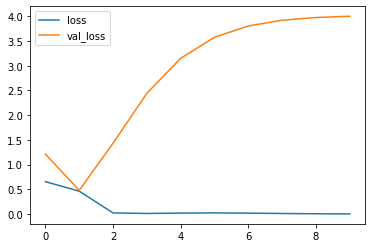

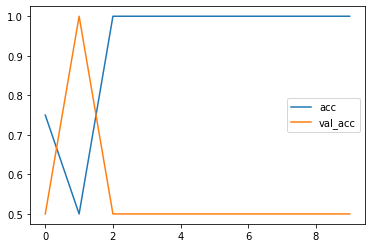

In [10]:
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

In [ ]:
#for layer in base_model.layers:
#    layer.trainable = True
    
#optimizer = keras.optimizers.Adam(lr=0.01, decay=0.01)
#model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# try:
#     class_weight
#     print("Training on an imbalanced ratio")
#     history = model.fit(x=train_images, y=train_labels,
#                     validation_data=(valid_images, valid_labels),
#                     epochs=5, batch_size=None, class_weight=class_weight)
# except NameError:
#     print("Training on 1:1 ratio")
#     history = model.fit(x=train_images, y=train_labels,
#                 validation_data=([valid_images, valid_labels]),
#                 epochs=1, batch_size=64)

#### 4.4 : Test the resulting model

In [12]:
#Test the resulting model on the test set to get evaluate the accuracy (I have obtained accuracies of up to 90% on a defect detection task)
res = model.evaluate(test_images, test_labels)
print(test_labels)
#plt.imshow(valid_images[8], cmap='gray')
print(res)

2/2 [==============================] - 0s 52ms/sample - loss: 4.1871 - acc: 0.5000
[1 0]
[4.18712043762207, 0.5]


#### 4.5 : Save the model
#### The below code saves the trained weights to the /weights folder

In [13]:
date_time = datetime.today().strftime("%Y%m%d_%H%M")

str_val_loss = str(history.history["val_loss"][-1]).split('.')[-1][:5]
str_val_acc = str(history.history["val_acc"][-1]).split('.')[-1][:5]
model.save("models/ResNet50_" + date_time + "_ValLoss_" + str_val_loss + "_ValAcc_" + str_val_acc + "_yourcomment.h5")
model.save_weights("weights/ResNet50_" + date_time + "_ValLoss_" + str_val_loss + "_ValAcc_" + str_val_acc + "yourcomment.h5")

# 5.0: Manual Testing on local images (Classifier)
---
#### The below code will load the model and perform classification.
#### When prompted choose a folder that contains new images that was not used for training or ...... it up to you. (Prompt defaults to the recording folder in the repo.)
#### A random dataset folder with mixed data from the two classes
#### The codes below will perform classification according to the required threshold* and classifiy the images
#### The classified images will be stored in respective folders with the "./inspection folder"

#### 5.1: Load the models for inference 

In [14]:
#Load the models
root = tk.Tk()
model_path = tkinter.filedialog.askopenfilename(title="Choose a model",
                                                          initialdir="./models")
root.destroy()
loaded_model = keras.models.load_model(model_path)
print("Model loaded succesfully - Ignore deprecation warnings")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### 5.2: Perform inference 

In [16]:
root = tk.Tk()
online_test_folder = tkinter.filedialog.askdirectory(title="Select the folder containing the images",
                     initialdir="./recordings")
root.destroy()

threshold = 0.5
X_online_test = []
print("Processing ...")

for i, img_file in enumerate(os.listdir(online_test_folder)):
    if img_file == "classified":
        continue

    img_path = os.path.join(online_test_folder, img_file)
    test_img = cv2.imread(img_path)
    
    if test_img is None:
        print(img_path)
        continue
        
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    style="square"
    finalized_img = process_grayscale(test_img_rgb, style=style)
    X_online_test.append(finalized_img)
    

images_online_test = np.array(X_online_test, dtype=float)
images_online_test_copy = images_online_test.copy()
processed_images_online_test = keras.applications.resnet50.preprocess_input(images_online_test_copy)
print("Done!")

Processing ...
Done!


#### 5.3: Output Inference results 

In [49]:
print(" ..\n")
predictions = np.squeeze(loaded_model.predict(processed_images_online_test))


c1_online_test = images_online_test[predictions < threshold]
c2_online_test = images_online_test[predictions >= threshold]
# print(predictions)

print(np.sum(predictions > 0.5), np.sum(predictions <=0.5))
percent_good_online_test = round(good_online_test.shape[0] / images_online_test.shape[0], 2) * 100
percent_def_online_test = round(def_online_test.shape[0] / images_online_test.shape[0], 2) * 100
print(f"""Out of {images_online_test.shape[0]} images
{(percent_good_online_test):.2f} were Class1 ({good_online_test.shape[0]} images)
{percent_def_online_test:.2f} were Class2 ({def_online_test.shape[0]} images)""")

print("\n\nDone!")

 ..

4 0
Out of 4 images
0.00 were Class1 (0 images)
100.00 were Class2 (4 images)


Done!


#### 5.4: Store the classified images into their respective folder for manual evaluation

In [25]:
pwd = os.getcwd()
date_time = datetime.today().strftime("%Y%m%d_%H%M")
tr_val_loss = str(history.history["val_loss"][-1]).split('.')[-1][:5]
str_val_acc = str(history.history["val_acc"][-1]).split('.')[-1][:5]


dir_path = os.path.join(pwd, "inspection")
dir_path = os.path.join(dir_path, "ResNet50_100Test_" + date_time + "_ValLoss_" + str_val_loss + "_ValAcc_" + str_val_acc)
c1_path = os.path.join(dir_path, "class1_" + str(threshold))
c2_path = os.path.join(dir_path, "class2_" + str(threshold))

# dir_path = os.path.join(pwd, "ResNet50_20200917_1224_ValLoss_01220_ValAcc_995")

In [26]:
#Store the first class/good into folder to identify misclassifications
os.makedirs(c1_path)
c1_preds = predictions[predictions < threshold]
counter = 0
for i_img, p_pred in zip(c1_online_test, c1_preds):
    im_name = str(counter) + "_" + str(p_pred) + ".png"
    cv2.imwrite(os.path.join(c1_path, im_name), i_img)
    counter += 1

In [27]:
#Store the second class/defective into folder to identify misclassifications
os.makedirs(c2_path)
c2_preds = predictions[predictions >= threshold]
counter = 0
for i_img, p_pred in zip(c2_online_test, c2_preds):
    im_name = str(counter) + "_" + str(p_pred) + ".png"
    cv2.imwrite(os.path.join(c2_path, im_name), i_img)
    counter += 1

# END OF NOTEBOOK